## Load Data

In [29]:
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from tqdm.auto import tqdm
import glob
import sys
sys.path.append('../')

ptable = Chem.GetPeriodicTable()

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  

from eval_utils import ModelResults

# result_dir = '/sharefs/share/sbdd_data/test_set/*/*.sdf'
# ref_fns = glob.glob(result_dir)
# ref_results = [{'mol': Chem.SDMolSupplier(fn)[0]} for fn in ref_fns]

# ref = ModelResults('Reference', '/sharefs/share/sbdd_data/test_set/eval_all.pt')
# ref.flat_results = ref_results

result_dir = '/sharefs/share/sbdd_data/all_results'
ref_path = os.path.join(result_dir, 'crossdocked_test_vina_docked.pt')
ar_path = os.path.join(result_dir, 'ar_vina_docked.pt')
tg_path = os.path.join(result_dir, 'targetdiff_vina_docked.pt')
p2m_path = os.path.join(result_dir, 'pocket2mol_vina_docked.pt')
molcraft_path = os.path.join(result_dir, 'bfn_vina_docked.pt')
train_path = os.path.join(result_dir, 'crossdocked_train_vina_docked.pt')
dcmp_path = os.path.join(result_dir, 'decompdiff_vina_docked.pt')
dcmp_ref_path = os.path.join(result_dir, 'decompdiff_ref_vina_docked.pt')


ref = ModelResults('Reference', ref_path)
# ref = ModelResults('Training', train_path)
ar = ModelResults('AR', ar_path)
p2m = ModelResults('Pocket2Mol', p2m_path)
tg = ModelResults('TargetDiff', tg_path)
dcmp = ModelResults('DecompDiff', dcmp_ref_path)
molcraft = ModelResults('MolCRAFT', molcraft_path)

ref.load_vina_docked()

models = [ar, p2m, tg, dcmp, molcraft]

ours = ModelResults('Ours', '/sharefs/qiukeyue/project/ours_ref.pt')
# models.append(ours)
# ours = ModelResults('Ours', '../../logs/qiukeyue_bfn_sbdd/train_multi_kekulize/4b71cc6_26712/test_outputs/20250118-143512/tmp.sdf_docked/eval_all.pt')
ours.load_from_one_sdf('/sharefs/qiukeyue/project/ours_ref_new.sdf')

for model in models:
    model.load_vina_docked()

models.append(ours)

Training loaded 99949 vina docked results


In [2]:
print(len(ours.flat_results))

9815


## Distance & Bond Length

(6, 6, 4), #	C:C	782857	30.6%	1.142938631351973	1.7068943385481106	0.005639557071961376
(6, 6, 1), #	CC	610364	23.9%	0.4050066952157783	1.9699614375504688	0.015649547423346906
(6, 7, 1), #	CN	271256	10.6%	0.6642226033908172	1.8957059323498233	0.012314833289590061
(6, 8, 1), #	CO	243829	9.5%	0.7041734069425528	1.8630354652329497	0.01158862058290397
(6, 7, 4), #	C:N	240494	9.4%	1.0681184477979142	1.6854616795586266	0.006173432317607124
(6, 8, 2), #	C=O	97628	3.8%	0.45222623395978956	1.6509591265448413	0.011987328925850518


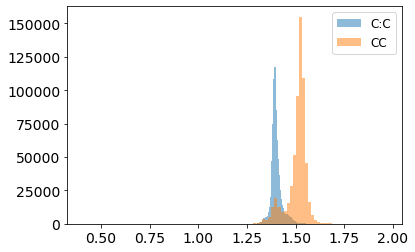

In [31]:
from core.evaluation.utils import eval_bond_length

bond_lengths = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    bond_lengths += eval_bond_length.bond_distance_from_mol(mol)

profile = eval_bond_length.get_bond_lengths(bond_lengths)

N_BINS = 100

# plt.hist(ref.all_c_c_distance, bins=N_BINS, label='all c c pairs', alpha=0.5)

allowed_bond_types = []

# only allow top 6 bond types
profile_filtered = {}

for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(bond_lengths) * 100
    if freq < 10:
        continue

    # if freq > 105:
    if freq > 70000:
        allowed_bond_types.append(k)
        bond_type_str = eval_bond_length._bond_type_str(k)
        if k[0] == k[1] == 6:
            plt.hist(profile[k], bins=N_BINS, label=bond_type_str, alpha=0.5)
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{bond_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')

plt.legend()
plt.show()

In [32]:
profiles_len = []

ref_profile_len = profile
N_BINS = 100

for model in models:
    bond_lengths = []
    for res in model.flat_results:
        try:
            mol = res['mol']
            mol = Chem.RemoveAllHs(mol)
            bond_lengths += eval_bond_length.bond_distance_from_mol(mol)
        except Exception as e:
            print(e, model.name)
    profiles_len.append(eval_bond_length.get_bond_lengths(bond_lengths))


C:C


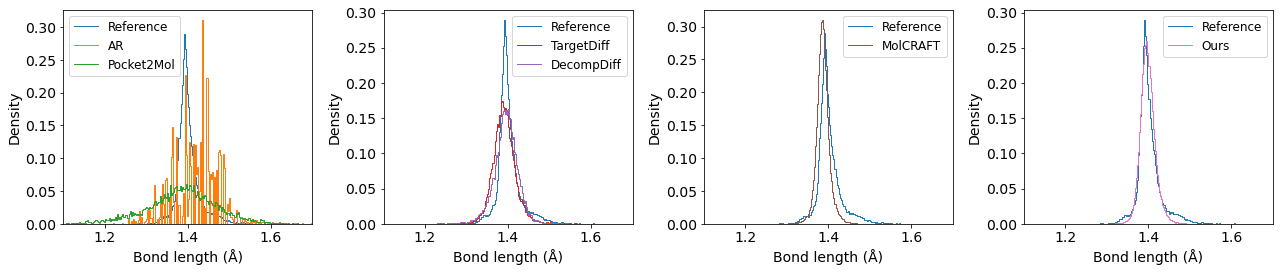

CC


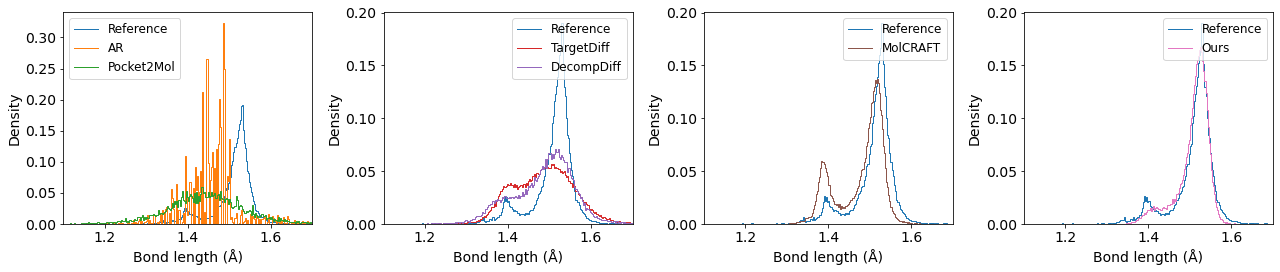

CN


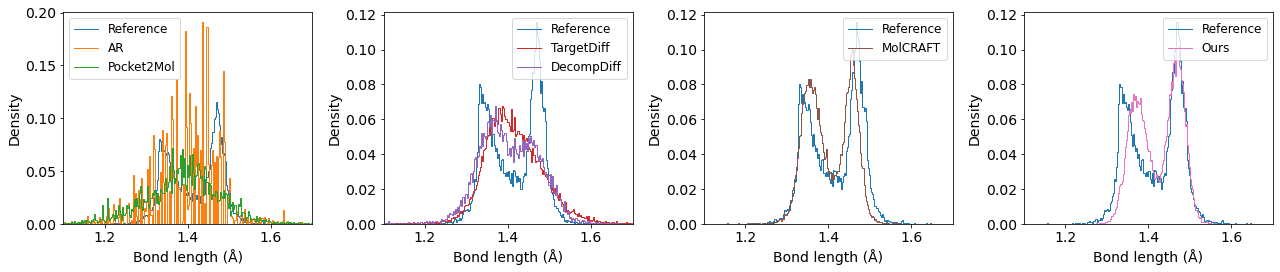

CO


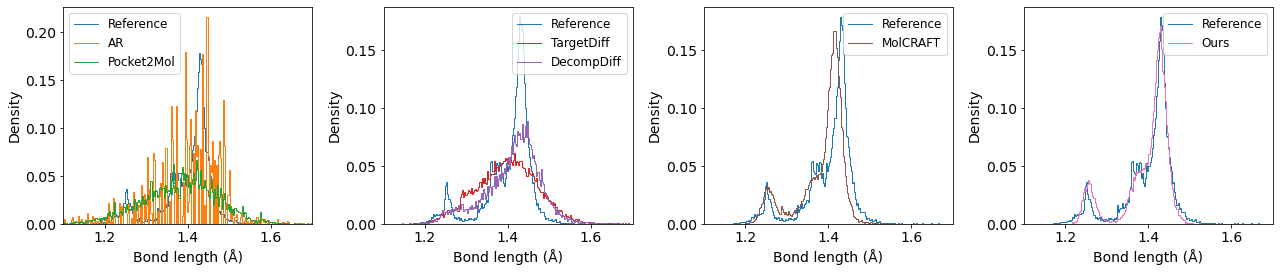

C:N


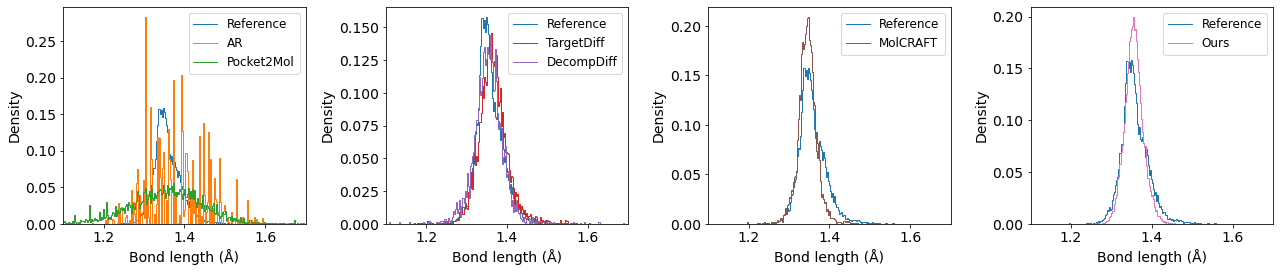

C=O


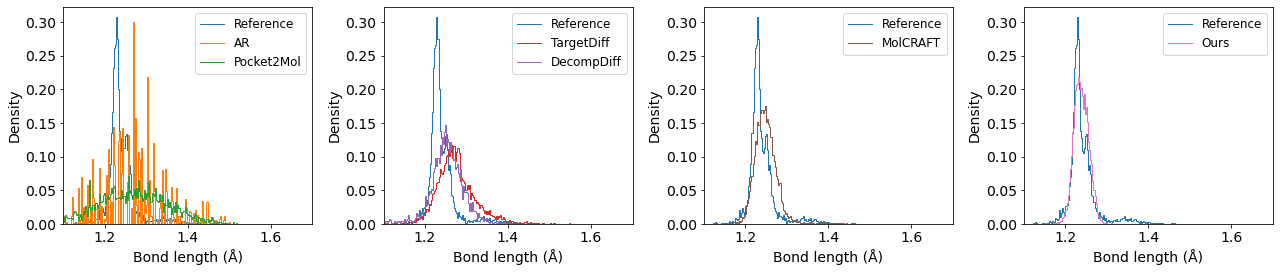

In [33]:
from scipy import spatial as sci_spatial
from scipy.stats import wasserstein_distance
import seaborn as sns

BOND_LENGTH_BINS = np.arange(1.1, 1.70001, 0.005)
BOND_LENGTH_BINS_2 = np.arange(1.1, 1.70001, 0.0025)

if 'train' in ref.path:
    BOND_LENGTH_BINS = BOND_LENGTH_BINS_2
# BOND_RANGE = (1.1, 1.7)
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:red', 'tab:pink', 'tab:purple', 'tab:gray', 'tab:cyan', 'tab:brown'] 

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

group1 = [ar, p2m]
group2 = [tg, dcmp]
group3 = [molcraft]
group4 = [ours]

BOND = (6, 7, 1)
LINE_WIDTH = 1

bond_len_results = []
ref_profile = ref_profile_len
profiles = profiles_len
for BOND in allowed_bond_types:
    ref_dist = np.histogram(ref_profile[BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100

    plt.figure(figsize=(6*3, 4))  # Adjust figure size for one row with four columns
    
    # Group 1
    plt.subplot(1, 4, 1)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group1):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+1])
        bond_len_results.append({
            'bond': eval_bond_length._bond_type_str(BOND),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()

    # Group 2
    plt.subplot(1, 4, 2)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group2):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+len(group1)+1])
        bond_len_results.append({
            'bond': eval_bond_length._bond_type_str(BOND),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()

    # Group 3
    plt.subplot(1, 4, 3)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group3):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+len(group1)+len(group2)+1])
        bond_len_results.append({
            'bond': eval_bond_length._bond_type_str(BOND),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()

    # Group 4
    plt.subplot(1, 4, 4)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group4):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+len(group1)+len(group2)+len(group3)+1])
        bond_len_results.append({
            'bond': eval_bond_length._bond_type_str(BOND),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()

    print(f'{eval_bond_length._bond_type_str(BOND)}')
    plt.savefig(f'fig_icml/{eval_bond_length._bond_type_str(BOND).replace(":", "_")}_length.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
import pandas as pd
df_bond_len = pd.DataFrame(bond_len_results)

# calculate the mean JSD for each model
df_bond_len.groupby('model')['jsd'].mean()

model
AR            0.541712
DecompDiff    0.322516
MolCRAFT      0.314867
Ours          0.248203
Pocket2Mol    0.465410
TargetDiff    0.348879
Name: jsd, dtype: float64

In [34]:
import pandas as pd
df_bond_len = pd.DataFrame(bond_len_results)

# calculate the mean JSD for each model
df_bond_len.groupby('model')['jsd'].mean()

model
AR            0.552589
DecompDiff    0.220954
MolCRAFT      0.225614
Ours          0.156081
Pocket2Mol    0.400079
TargetDiff    0.264327
Name: jsd, dtype: float64

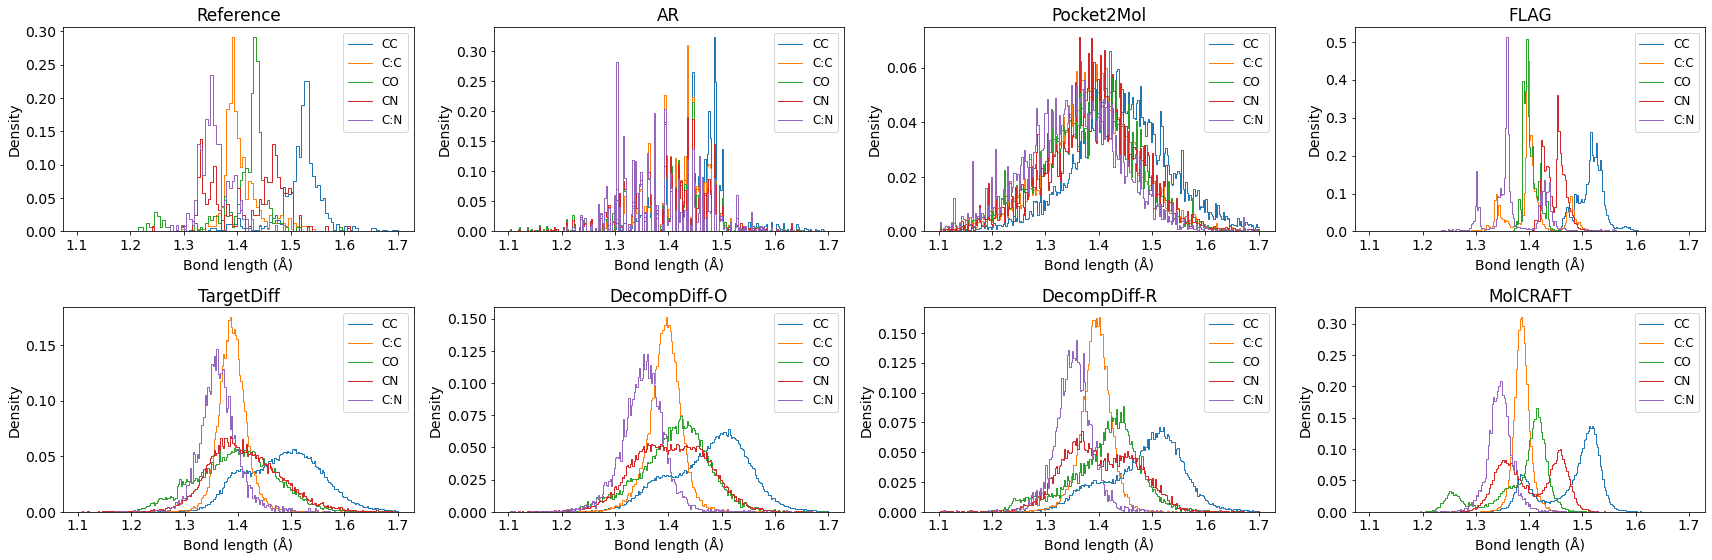

In [16]:
BINS = np.arange(1.1, 1.70001, 0.005)
BINS2 = np.arange(1.1, 1.70001, 0.0025)

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

plt.figure(figsize=(6*3, 4*2))
for idx, model in enumerate(models):
    plt.subplot(2, 4, idx+1)
    if idx == 0:
        bins = BINS
    else:
        bins = BINS2
    for BOND in allowed_bond_types:
        model_dist = np.histogram(profiles[idx][BOND], bins=bins, density=True)[0] / 100
        plt.step(bins[1:], model_dist, linewidth=1, label=f'{eval_bond_length._bond_type_str(BOND)}')
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()
    plt.title(model.name)
# plt.savefig(f'figs/all_length.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Bond Angle

(6, 4, 6, 4, 6), #	C:C:C	748095	23.8%	87.55419806978725	147.4179645922777	0.5986376652249047
(6, 1, 6, 1, 6), #	CCC	361219	11.5%	45.04342985627139	179.0018306449689	1.339584007886975
(6, 4, 6, 4, 7), #	C:C:N	191337	6.1%	93.53542745994886	146.41620703313268	0.5288077957318381
(6, 1, 6, 1, 7), #	CCN	181230	5.8%	54.80987185771927	179.21472218371505	1.2440485032599577
(6, 1, 6, 1, 8), #	CCO	177612	5.7%	50.848213599386774	165.63992481559094	1.1479171121620417
(6, 1, 6, 4, 6), #	CC:C	135349	4.3%	86.4416336734345	153.87087664260895	0.6742924296917445


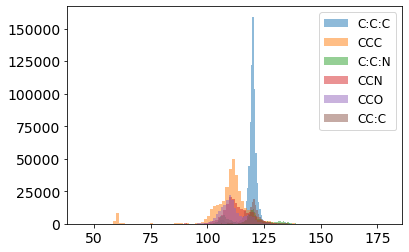

In [36]:
from core.evaluation.utils import eval_bond_angle

bond_angles = []
kekulize = False
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    if kekulize:
        Chem.Kekulize(mol)
    bond_angles += eval_bond_angle.bond_angle_from_mol(mol)

profile = eval_bond_angle.get_bond_angles(bond_angles)

N_BINS = 100

allowed_angle_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(bond_angles) * 100
    if freq < 10:
        continue

    if 'train' in ref.path:
        freq_threshold = 120000
    else:
        freq_threshold = 100
    if freq > freq_threshold:
        allowed_angle_types.append(k)
        angle_type_str = eval_bond_angle._angle_type_str(k)
        plt.hist(profile[k], bins=N_BINS, label=angle_type_str, alpha=0.5)
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{angle_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')
plt.legend()
plt.show()

In [37]:
# import counter
from collections import Counter

ref_profile_angle = profile
profiles_angle = []

error_models = []
for model in models:
    bond_angles = []
    if model == ref:
        profiles_angle.append(ref_profile_angle)
        continue
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        if kekulize:
            Chem.Kekulize(mol)
        bond_angles += eval_bond_angle.bond_angle_from_mol(mol)
    profiles_angle.append(eval_bond_angle.get_bond_angles(bond_angles))


C:C:C
CCC
C:C:N
CCN
CCO
CC:C


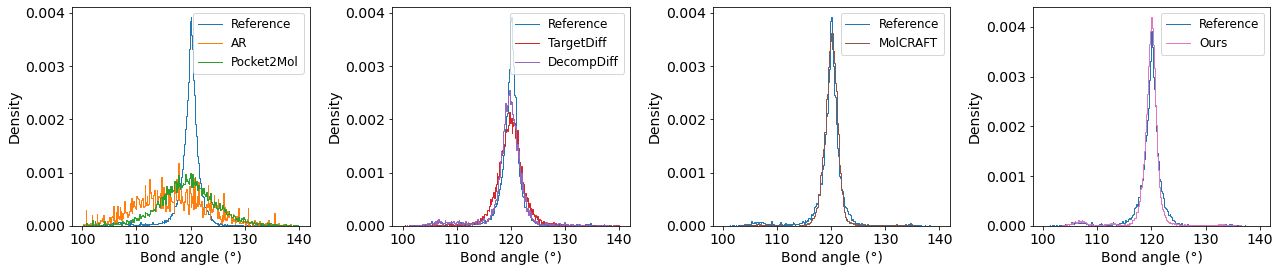

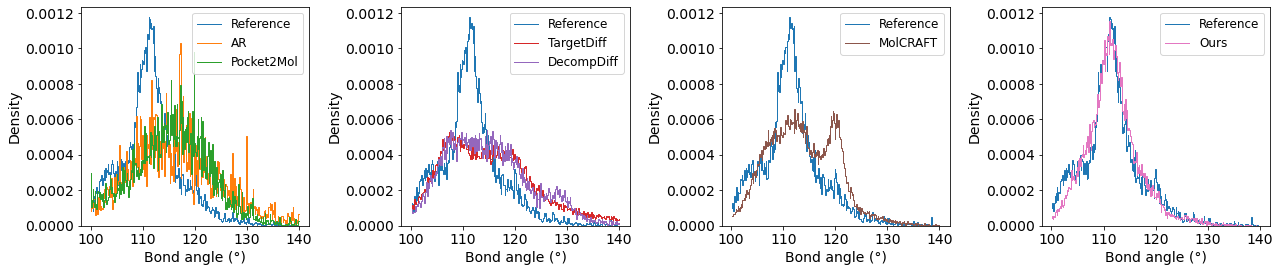

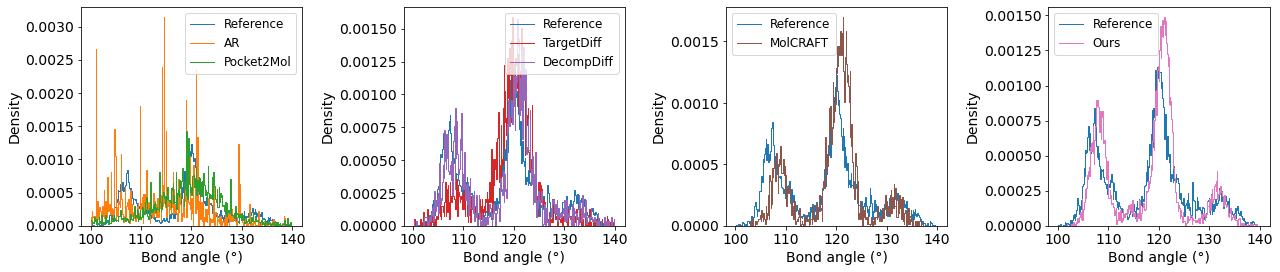

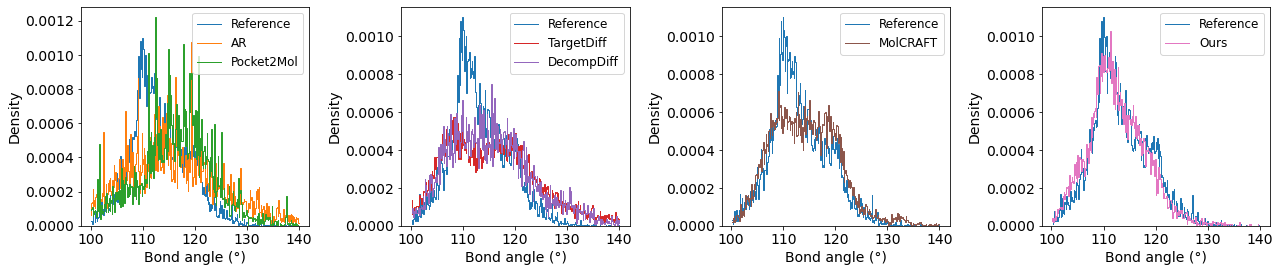

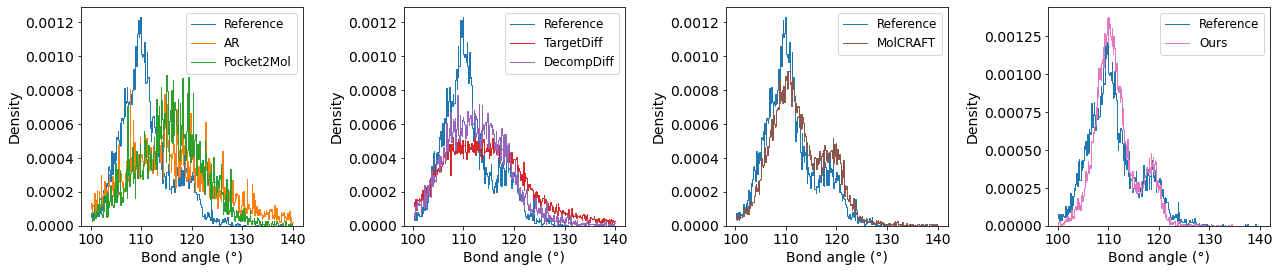

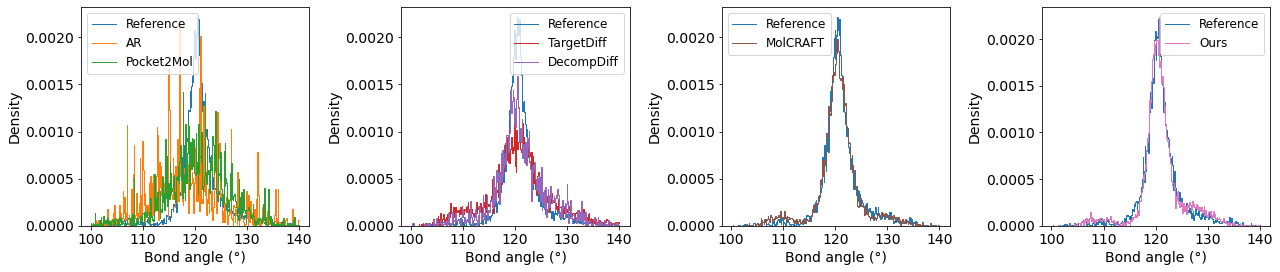

In [38]:
BOND_ANGLE_BINS = np.arange(100, 140.001, 0.25)
BOND_ANGLE_BINS_2 = np.arange(100, 140.001, 0.125)

if 'train' in ref.path:
    BOND_ANGLE_BINS = BOND_ANGLE_BINS_2

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
})

LINE_WIDTH = 1

group1 = [ar, p2m]  # Updated group 1
group2 = [tg, dcmp]  # Updated group 2
group3 = [molcraft]  # Updated group 3
group4 = [ours]  # Updated group 4

bond_angle_results = []
ref_profile = ref_profile_angle
profiles = profiles_angle
for ANGLE in allowed_angle_types:
    ref_dist = np.histogram(ref_profile[ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100

    plt.figure(figsize=(6*3, 4))  # Adjusting the figure size to have 4 columns

    # Plot for group1
    plt.subplot(1, 4, 1)
    plt.step(BOND_ANGLE_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group1):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][ANGLE], bins=BOND_ANGLE_BINS_2, density=True)[0] / 100
        plt.step(BOND_ANGLE_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+1])
        bond_angle_results.append({
            'angle': eval_bond_angle._angle_type_str(ANGLE),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Bond angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()

    # Plot for group2
    plt.subplot(1, 4, 2)
    plt.step(BOND_ANGLE_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group2):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][ANGLE], bins=BOND_ANGLE_BINS_2, density=True)[0] / 100
        plt.step(BOND_ANGLE_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+3])
        bond_angle_results.append({
            'angle': eval_bond_angle._angle_type_str(ANGLE),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Bond angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend(loc='upper right')
    plt.tight_layout()

    # Plot for group3
    plt.subplot(1, 4, 3)
    plt.step(BOND_ANGLE_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group3):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][ANGLE], bins=BOND_ANGLE_BINS_2, density=True)[0] / 100
        plt.step(BOND_ANGLE_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+5])
        bond_angle_results.append({
            'angle': eval_bond_angle._angle_type_str(ANGLE),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Bond angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()

    # Plot for group4
    plt.subplot(1, 4, 4)
    plt.step(BOND_ANGLE_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group4):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][ANGLE], bins=BOND_ANGLE_BINS_2, density=True)[0] / 100
        plt.step(BOND_ANGLE_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+6])  # Updated color index
        bond_angle_results.append({
            'angle': eval_bond_angle._angle_type_str(ANGLE),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Bond angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()

    # Show plot for all subplots
    print(f'{eval_bond_angle._angle_type_str(ANGLE)}')
    plt.savefig(f'fig_icml/{eval_bond_angle._angle_type_str(ANGLE).replace(":", "_")}_angle.pdf', dpi=300, bbox_inches='tight')


In [10]:
df_bond_angle = pd.DataFrame(bond_angle_results)
df_bond_angle.groupby('model')['jsd'].mean()

model
AR            0.506963
DecompDiff    0.410158
MolCRAFT      0.384290
Ours          0.351284
Pocket2Mol    0.482115
TargetDiff    0.434624
Name: jsd, dtype: float64

In [39]:
df_bond_angle = pd.DataFrame(bond_angle_results)
df_bond_angle.groupby('model')['jsd'].mean()

model
AR            0.372168
DecompDiff    0.201516
MolCRAFT      0.165094
Ours          0.135692
Pocket2Mol    0.319894
TargetDiff    0.246019
Name: jsd, dtype: float64

## Torsion Angle

In [47]:
from core.evaluation.utils import eval_torsion_angle

kekulize = False

torsion_angles = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    if kekulize:
        Chem.Kekulize(mol)
    torsion_angles += eval_torsion_angle.torsion_angle_from_mol(mol)

profile = eval_torsion_angle.get_torsion_angles(torsion_angles)
N_BINS = 100

allowed_torsion_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(torsion_angles) * 100
    if freq < 10:
        continue

    if 'train' in ref.path:
        freq_threshold = 100000
    else:
        freq_threshold = 100
    if freq > freq_threshold:
        allowed_torsion_types.append(k)
        torsion_type_str = eval_torsion_angle._torsion_type_str(k)
        # plt.hist(profile[k], bins=N_BINS, label=torsion_type_str, alpha=0.5, density=False)
        # plt.legend()
        # plt.show()
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{torsion_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')

(6, 4, 6, 4, 6, 4, 6), #	C:C:C:C	735761	18.8%	-180.0	180.0	3.6
(6, 1, 6, 1, 6, 1, 6), #	CCCC	265736	6.8%	-179.9996452756085	179.99936363309055	3.5999900890869903
(6, 4, 6, 4, 7, 4, 6), #	C:C:N:C	181717	4.6%	-179.9999973510075	179.9999890674056	3.599999864184131
(6, 1, 6, 1, 7, 1, 6), #	CCNC	178982	4.6%	-179.99998291954105	179.99987679084933	3.599998597103904
(6, 4, 6, 4, 6, 4, 7), #	C:C:C:N	152132	3.9%	-179.99995651914415	179.99995651914415	3.599999130382883
(6, 4, 6, 4, 6, 1, 6), #	C:C:CC	127630	3.3%	-180.0	180.0	3.6
(6, 1, 6, 4, 6, 4, 6), #	CC:C:C	124180	3.2%	-180.0	179.99997480597236	3.5999997480597234
(6, 1, 6, 1, 6, 1, 8), #	CCCO	109462	2.8%	-179.9993233194685	179.99956672998763	3.5999889004945613
(6, 4, 7, 4, 6, 4, 7), #	C:N:C:N	105078	2.7%	-179.99996570855896	179.9999868115464	3.5999995252010537
(6, 1, 6, 1, 6, 1, 7), #	CCCN	102529	2.6%	-179.9995601193787	179.9997727087789	3.599993328281576


In [48]:
ref_profile_torsion = profile
profiles_torsion = []
# models = [p2m, tg, dcmp, bfn, bfn_mols, bfn_mols_v1]

# models = [ar, p2m, tg, dcmp, molcraft, ours]
for model in models:
    torsion_angles = []
    if model == ref:
        profiles_torsion.append(ref_profile_torsion)
        continue
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        if kekulize:
            Chem.Kekulize(mol)
        try:
            torsion_angles += eval_torsion_angle.torsion_angle_from_mol(mol)
        except:
            continue
            print(f'Error in {model.name}')
    profiles_torsion.append(eval_torsion_angle.get_torsion_angles(torsion_angles))

C_C_C_C
CCCC
C_C_N_C
CCNC
C_C_C_N
C_C_CC
CC_C_C
CCCO
C_N_C_N
CCCN


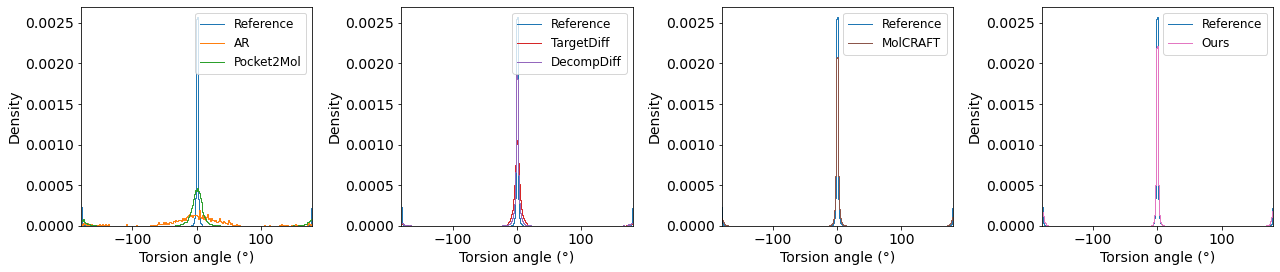

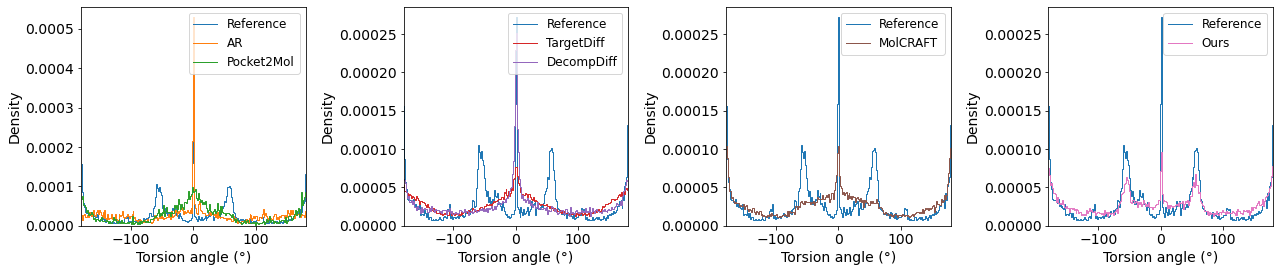

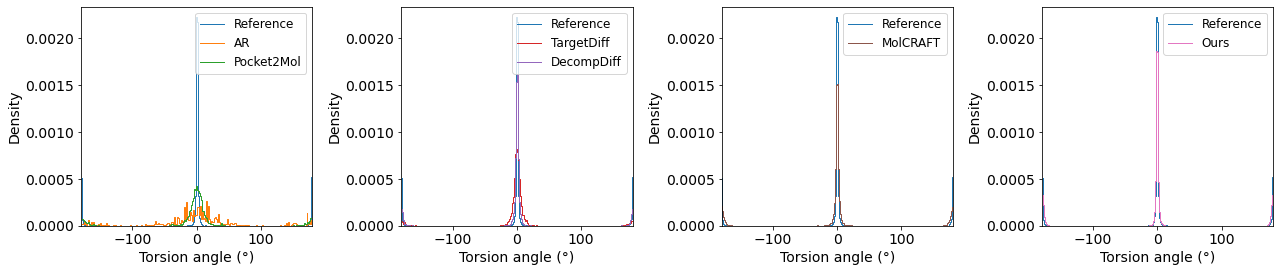

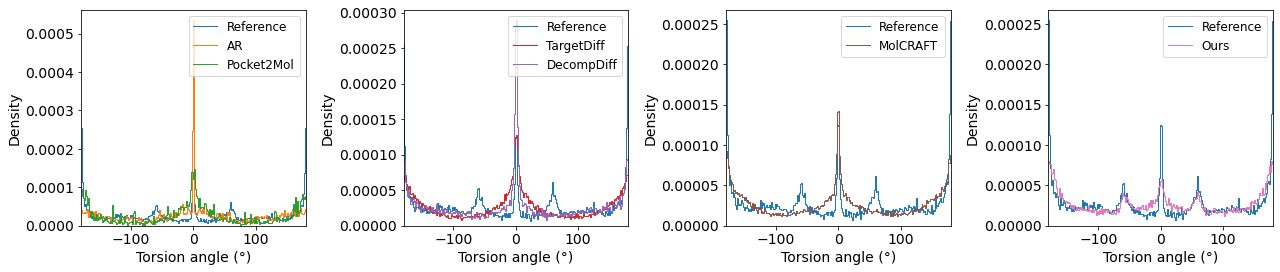

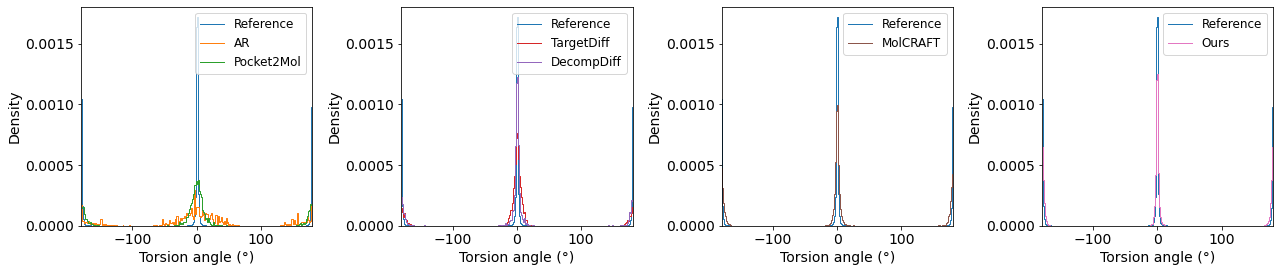

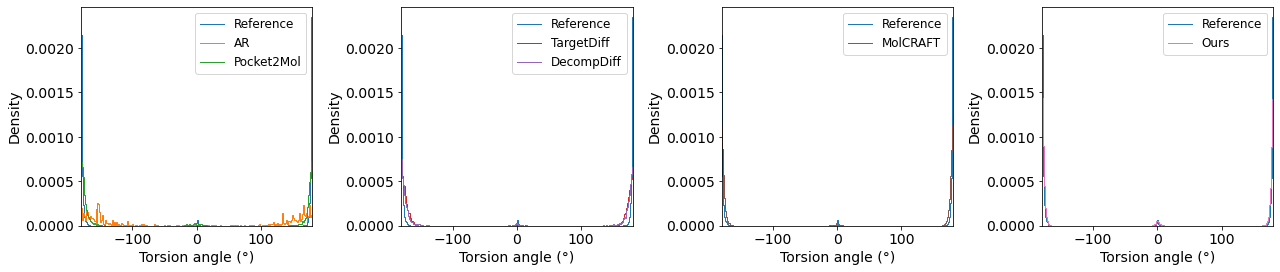

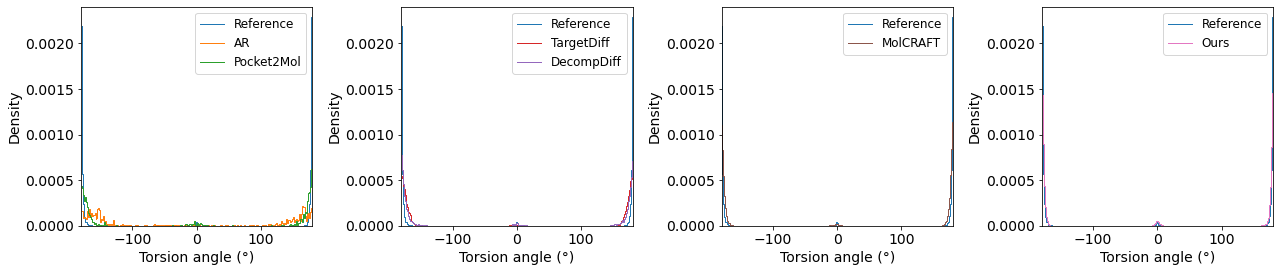

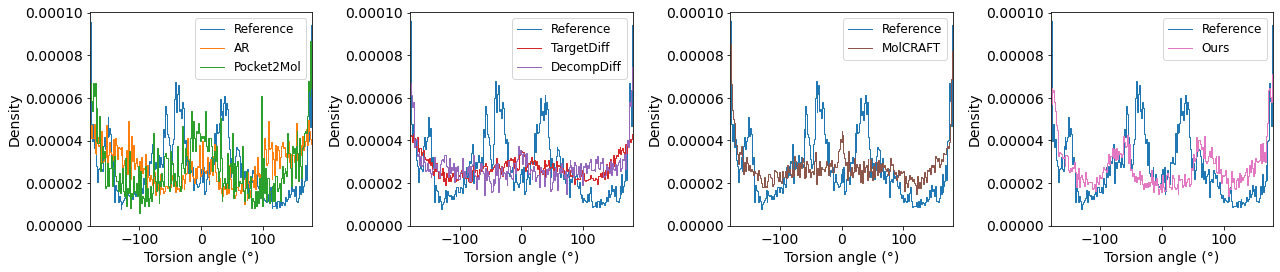

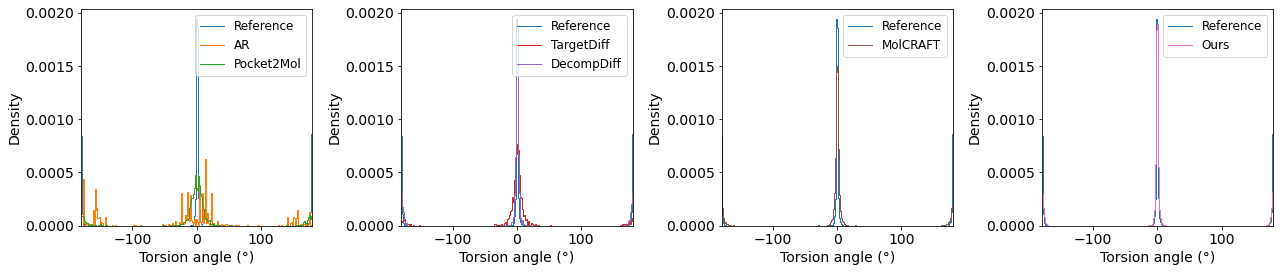

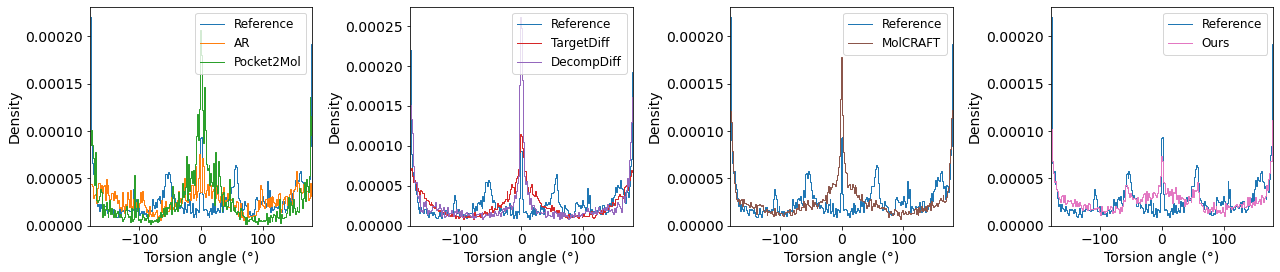

In [49]:
from scipy import spatial as sci_spatial

N_BINS = np.arange(-180, 181, 3)
N_BINS_2 = np.arange(-180, 181, 1.5)
LINE_WIDTH = 1

if 'train' in ref.path:
    N_BINS = N_BINS_2

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

group1 = [ar, p2m]
group2 = [tg, dcmp]
group3 = [molcraft]
group4 = [ours]  # Added the new group

torsion_results = []
ref_profile = ref_profile_torsion
profiles = profiles_torsion
for TORSION in allowed_torsion_types:
    ref_dist = np.histogram(ref_profile[TORSION], bins=N_BINS, density=True)[0] / 100

    plt.figure(figsize=(6*3, 4))
    
    # Group 1 plot
    plt.subplot(1, 4, 1)
    plt.step(N_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group1):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][TORSION], bins=N_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][TORSION], bins=N_BINS_2, density=True)[0] / 100
        plt.step(N_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+1])
        torsion_results.append({
            'torsion': eval_torsion_angle._torsion_type_str(TORSION),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Torsion angle (°)')
    plt.ylabel('Density')
    plt.xlim(-180, 180)
    plt.ylim(0)
    plt.legend(loc='upper right')
    plt.tight_layout()

    # Group 2 plot
    plt.subplot(1, 4, 2)
    plt.step(N_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group2):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][TORSION], bins=N_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][TORSION], bins=N_BINS_2, density=True)[0] / 100
        plt.step(N_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+3])
        torsion_results.append({
            'torsion': eval_torsion_angle._torsion_type_str(TORSION),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Torsion angle (°)')
    plt.ylabel('Density')
    plt.xlim(-180, 180)
    plt.ylim(0)
    # set legend to upper right
    plt.legend(loc='upper right')
    plt.tight_layout()

    # Group 3 plot
    plt.subplot(1, 4, 3)
    plt.step(N_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group3):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][TORSION], bins=N_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][TORSION], bins=N_BINS_2, density=True)[0] / 100
        plt.step(N_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+5])
        torsion_results.append({
            'torsion': eval_torsion_angle._torsion_type_str(TORSION),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Torsion angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.xlim(-180, 180)
    plt.legend(loc='upper right')
    plt.tight_layout()

    # Group 4 plot (New)
    plt.subplot(1, 4, 4)
    plt.step(N_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group4):
        model_idx = models.index(model)
        model_dist = np.histogram(profiles[model_idx][TORSION], bins=N_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[model_idx][TORSION], bins=N_BINS_2, density=True)[0] / 100
        plt.step(N_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name}', color=colors[idx+6])  # Adjust color index
        torsion_results.append({
            'torsion': eval_torsion_angle._torsion_type_str(TORSION),
            'model': model.name,
            'jsd': jsd
        })
    plt.xlabel('Torsion angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.xlim(-180, 180)
    plt.legend(loc='upper right')
    plt.tight_layout()

    # Save or display the figure
    print(f'{eval_torsion_angle._torsion_type_str(TORSION).replace(":", "_")}')
    plt.savefig(f'fig_icml/{eval_torsion_angle._torsion_type_str(TORSION).replace(":", "_")}_angle.pdf', dpi=300, bbox_inches='tight')


In [14]:
df_torsion = pd.DataFrame(torsion_results)
df_torsion.groupby('model')['jsd'].mean()

model
AR            0.544684
DecompDiff    0.337713
MolCRAFT      0.322221
Ours          0.286985
Pocket2Mol    0.466510
TargetDiff    0.411248
Name: jsd, dtype: float64

In [50]:
df_torsion = pd.DataFrame(torsion_results)
df_torsion.groupby('model')['jsd'].mean()

model
AR            0.513164
DecompDiff    0.276630
MolCRAFT      0.230193
Ours          0.168781
Pocket2Mol    0.413194
TargetDiff    0.360813
Name: jsd, dtype: float64